In [5]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import grad, Variable
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

D_r = 5
D_rh = int(D_r/2)
D_rhh = int(D_rh/2)

def get_optim(model):
    return optim.Adam(model.parameters(), betas = (0.5, 0.999), lr = 0.0002)

def interpolate(real_img, fake_img):
    N = real_img.shape[0]
    theta = torch.tensor(np.random.uniform(size = N), dtype = torch.float).view(N, 1, 1, 1).cuda()
    sample = theta * real_img + (1 - theta) * fake_img
    return sample

def gradient_norm(model, real_img, fake_img):
    N = real_img.shape[0]
    _input = interpolate(real_img, fake_img)
    _input = Variable(_input, requires_grad = True)
    score = model(_input)
    outputs = torch.zeros(score.shape).cuda()
    gradient = grad(outputs = score, 
                    inputs = _input, 
                    grad_outputs = outputs,
                    create_graph = True,
                    retain_graph = True,
                    only_inputs = True)[0]
    grad_norm = (gradient.view(N, -1).norm(p = 2) - 1)**2
    return grad_norm


class Generator(nn.Module):
    def __init__(self, latent_dim = 100):
        super(Generator, self).__init__()
        
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
                nn.ConvTranspose2d(self.latent_dim, D_r, 4, 2, 1, bias = False),
                nn.BatchNorm2d(D_r),
                nn.ReLU(),
                nn.ConvTranspose2d(D_r, D_rh, 4, 2, 1, bias = False),
                nn.BatchNorm2d(D_rh),
                nn.ReLU(),
                nn.ConvTranspose2d(D_rh, D_rhh, 4, 2, 1, bias = False),
                nn.BatchNorm2d(D_rhh),
                nn.ReLU(),
                nn.ConvTranspose2d(D_rhh, 64, 4, 2, 1, bias = False),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = input.unsqueeze(2).unsqueeze(3)
        return self.net(output)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
                nn.Conv2d(1, 64, 4, 2, 1, bias = False),
                nn.LeakyReLU(0.2),
                nn.Conv2d(64, D_rhh, 4, 2, 1, bias = False),
                nn.BatchNorm2d(D_rhh),
                nn.LeakyReLU(0.2),
                nn.Conv2d(D_rhh, D_rh, 4, 2, 1, bias = False),
                nn.BatchNorm2d(D_rh),
                nn.LeakyReLU(0.2),
                nn.Conv2d(D_rh, D_r, 4, 2, 1, bias = False),
                nn.BatchNorm2d(D_r),
                nn.LeakyReLU(0.2),
                nn.Conv2d(D_r, 1, 2, 1)
                )
    def forward(self, input):
        return self.net(input).view(-1)


def get_dataloader(batch_size, pad=False):
    if pad:
        transform = transforms.Compose([
                transforms.Pad(padding = 2, padding_mode = 'edge'),
                transforms.ToTensor()
                ])
    else:
        transform = transforms.ToTensor()
    
    dataset = datasets.MNIST(root = '../data', train = True, download = True, 
                    transform = transform)
    dataloader = DataLoader(dataset = dataset, batch_size = batch_size, 
                            shuffle = True)
    return dataloader

def makedirs(sample_dir, checkpoint_dir):
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

def get_optim(model, lr=0.002):
    return optim.Adam(model.parameters(), betas = [0.5, 0.999], lr = lr)

def interpolate(real_img, fake_img, device):
    N = real_img.shape[0]
    theta = torch.tensor(np.random.uniform(size = N), dtype = torch.float, device=device).view(N, 1, 1, 1)
    sample = theta * real_img + (1 - theta) * fake_img
    return sample

def gradient_norm(model, real_img, fake_img, device):
    N = real_img.shape[0]
    _input = interpolate(real_img, fake_img, device)
    _input = Variable(_input, requires_grad = True)
    score = model(_input)
    outputs = torch.zeros(score.shape, device=device)
    gradient = grad(outputs = score, 
                    inputs = _input, 
                    grad_outputs = outputs,
                    create_graph = True,
                    retain_graph = True,
                    only_inputs = True)[0]
    grad_norm = (gradient.view(N, -1).norm(p = 2) - 1)**2
    return grad_norm


Epochs: 100%|█████████████████████████████████████| 1/1 [01:08<00:00, 68.41s/it]


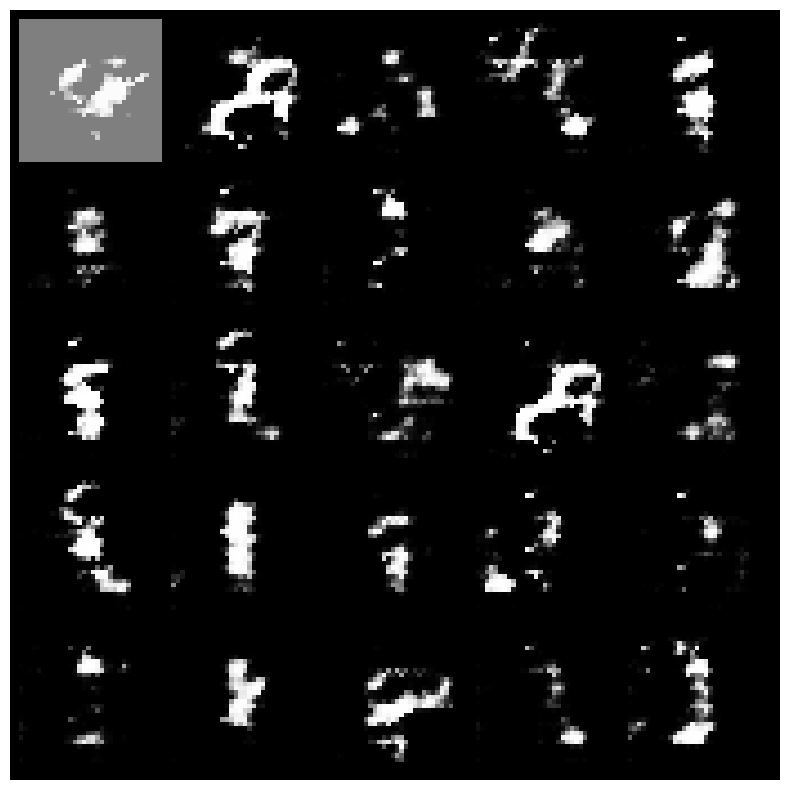

Generated images saved at ../data/mnist/wgangp/wgsamples/generated_samples.png


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

epochs = 1
batch_size = 100
latent_dim = 10
d_updates = 5
gp_weight = 10

dataloader = get_dataloader(batch_size, True)
step_per_epoch = np.ceil(dataloader.dataset.__len__() / batch_size)
sample_dir = '../data/mnist/wgangp/wgsamples'
checkpoint_dir = '../data/mnist/wgangp/checkpoints'

makedirs(sample_dir, checkpoint_dir)

G = Generator(latent_dim = latent_dim).to(device)
D = Discriminator().to(device)

g_optim = get_optim(G)
d_optim = get_optim(D)

g_log = []
d_log = []
    
fix_z = torch.randn(100, latent_dim).to(device)
for epoch_i in tqdm(range(1, epochs + 1), desc="Epochs"):
    for step_i, (real_img, _) in enumerate(dataloader):
        N = real_img.shape[0]
        
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        # Train D
        d_loss_avg = 0
        for _ in range(d_updates):
            real_img = real_img.to(device)
            z = torch.randn(N, latent_dim).to(device)
            fake_img = G(z)

            real_score = D(real_img)
            fake_score = D(fake_img)
            grad_penalty = gradient_norm(D, real_img, fake_img, device)
            d_loss = (fake_score - real_score + grad_penalty * gp_weight).mean()
            d_loss_avg += d_loss

            d_optim.zero_grad()
            d_loss.backward()
            d_optim.step()
        d_loss_avg /= d_updates
        d_log.append(d_loss_avg.item())
        
        # Train G
        z = torch.randn(N, latent_dim).to(device)
        fake_img = G(z)
        
        fake_score = D(fake_img).mean()
        
        g_loss = -fake_score
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
        g_log.append(g_loss.item())

    
# Save the final generator and discriminator models
torch.save(G.state_dict(), f"{checkpoint_dir}/generator_final.pth")
torch.save(D.state_dict(), f"{checkpoint_dir}/discriminator_final.pth")

# Generate images
num_samples = 25  # Number of images to generate
z = torch.randn(num_samples, latent_dim).to(device)  # Random latent vectors
with torch.no_grad():
    fake_images = G(z)

# Denormalize the images and convert them to a grid for visualization
fake_images = (fake_images + 1) / 2  # Assuming the generator outputs images in the range [-1, 1]
fake_images_grid = make_grid(fake_images, nrow=5, normalize=True, scale_each=True)

# Save the generated images
save_path = os.path.join(sample_dir, "generated_samples.png")
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(fake_images_grid.permute(1, 2, 0).cpu().numpy())
plt.savefig(save_path, bbox_inches="tight")
plt.show()

print(f"Generated images saved at {save_path}")


In [ ]:
from torchsummary import summary
summary(G)

In [1]:
784*400*2 + 400*10*3

639200